In [1]:
!pip install neptune-client

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.3/438.3 kB 1.4 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 kB 3.3 MB/s eta 0:00:00


In [1]:
from pathlib import Path
from typing import Dict, List, Optional

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.loggers import NeptuneLogger
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchmetrics
import torchvision
import torchvision.models as pretrained_models
import torchvision.transforms as transforms
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from torchvision import datasets
from tqdm import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning import Trainer


use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
seed = 42
num_workers = 2 if use_cuda else 4
torch.manual_seed(seed)


2022-11-26 16:48:11.516786: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-26 16:48:11.899918: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/matias/RECVIS:
2022-11-26 16:48:11.899934: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-26 16:48:11.941101: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-26 16:48:13.216855: W

In [3]:
from compact_transformers.src import cct_14_7x2_384
model = cct_14_7x2_384(pretrained=True, progress=True, )

Downloading: "https://shi-labs.com/projects/cct/checkpoints/finetuned/cct_14_7x2_384_imagenet.pth" to /home/matias/.cache/torch/hub/checkpoints/cct_14_7x2_384_imagenet.pth


  0%|          | 0.00/85.9M [00:00<?, ?B/s]

In [4]:
model

CCT(
  (tokenizer): Tokenizer(
    (conv_layers): Sequential(
      (0): Sequential(
        (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (1): ReLU()
        (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      )
      (1): Sequential(
        (0): Conv2d(64, 384, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (1): ReLU()
        (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      )
    )
    (flattener): Flatten(start_dim=2, end_dim=3)
  )
  (classifier): TransformerClassifier(
    (attention_pool): Linear(in_features=384, out_features=1, bias=True)
    (dropout): Dropout(p=0.0, inplace=False)
    (blocks): ModuleList(
      (0): TransformerEncoderLayer(
        (pre_norm): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
        (self_attn): Attention(
          (qkv): Linear(in_features=384, out_features=1152, bias=False)
          (attn_drop):

In [3]:
%reload_ext autoreload
%autoreload 2

In [5]:
class_to_idx = datasets.ImageFolder(
    "/kaggle/input/recvis3/bird_dataset/train_images_cropped",
).class_to_idx


class FullImageDataset(Dataset):
    def __init__(self, root_dir, class_to_idx, transform=None):
        self.root_dir = Path(root_dir)
        self.transform = transform
        self.files = [x for x in self.root_dir.glob("**/*") if x.is_file()]
        self.class_to_idx = class_to_idx

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx: int):
        img_path = self.files[idx]
        image = Image.open(img_path).convert("RGB")
        label = self.class_to_idx[img_path.parent.name]
        width = image.width
        height = image.height

        if self.transform is not None:
            image = self.transform(image)

        return {
            "image": image,
            "label": label,
            "path": img_path,
            "width": width,
            "height": height,
        }


def collate_batch(batch):
    images = torch.stack([elem["image"] for elem in batch])
    labels = [elem["label"] for elem in batch]
    paths = [elem["path"] for elem in batch]
    widths = [elem["width"] for elem in batch]
    heights = [elem["height"] for elem in batch]
    return {
        "images": images,
        "labels": labels,
        "paths": paths,
        "widths": widths,
        "heights": heights,
    }


class DataModule(pl.LightningDataModule):
    def __init__(
        self,
        config,
        path_to_datasets,
        class_to_idx,
        train_transforms,
        val_transforms,
    ):
        super().__init__()
        self.config = config
        self.path_to_datasets = Path(path_to_datasets)
        self.class_to_idx = class_to_idx
        self.train_transforms = train_transforms
        self.val_transforms = val_transforms

    def train_dataloader(self):
        return torch.utils.data.DataLoader(
            FullImageDataset(
                self.path_to_datasets / "train_images_cropped",
                transform=self.train_transforms,
                class_to_idx=class_to_idx,
            ),
            shuffle=True,
            batch_size=self.config["batch_size"],
            num_workers=self.config["num_workers"],
            collate_fn=collate_batch,
        )

    def val_dataloader(self):
        return torch.utils.data.DataLoader(
            FullImageDataset(
                self.path_to_datasets / "val_images_cropped",
                transform=self.val_transforms,
                class_to_idx=class_to_idx,
            ),
            batch_size=self.config["batch_size"],
            shuffle=False,
            num_workers=self.config["num_workers"],
            collate_fn=collate_batch,
        )

    def predict_dataloader(self):
        return torch.utils.data.DataLoader(
            FullImageDataset(
                self.path_to_datasets / "test_images_cropped",
                transform=self.val_transforms,
                class_to_idx=class_to_idx,
            ),
            batch_size=self.config["batch_size"],
            shuffle=False,
            num_workers=self.config["num_workers"],
            collate_fn=collate_batch,
        )


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


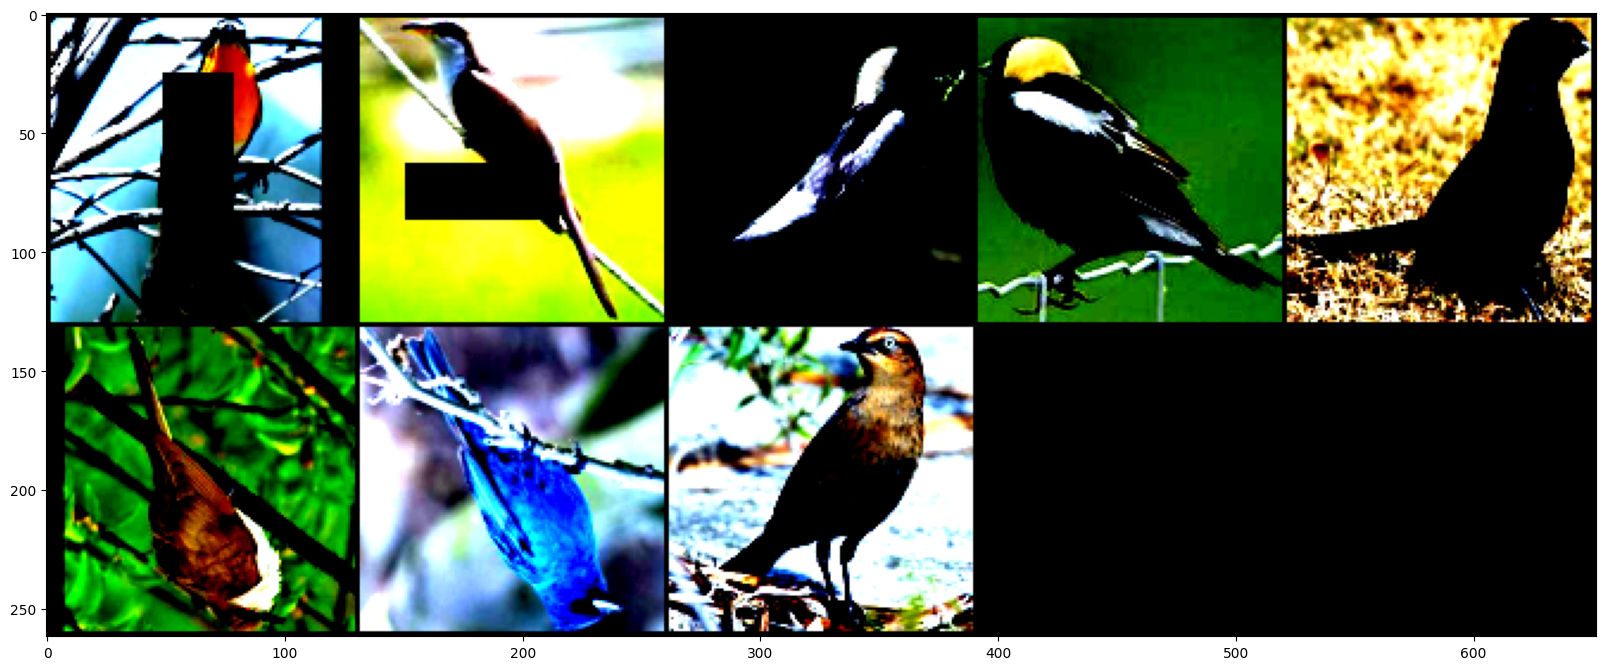

In [7]:
config = {}
config["batch_size"] = 8
config["width"] = 128
config["device"] = device
config["learning_rate"] = 0.0001
config["weight_decay"] = 0.01
config["num_workers"] = num_workers

data_transforms = transforms.Compose(
    [
        transforms.Resize((config["width"], config["width"])),
        # transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        #         transforms.ColorJitter(brightness=0.2, contrast=0.2),
        #         transforms.RandomAffine(degrees=15, translate=(0, 0.3), scale=(0.7, 1.3)),
        transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3)),
    ]
)

val_data_transforms = transforms.Compose(data_transforms.transforms[:3])

dm = DataModule(
    config,
    path_to_datasets="bird_dataset",
    train_transforms=data_transforms,
    val_transforms=val_data_transforms,
)

fig = plt.figure(figsize=(20, 20))
inputs, labels = next(iter(dm.train_dataloader()))
out = inputs.permute(0, 1, 2, 3)
out = torchvision.utils.make_grid(out, nrow=5)
out = np.transpose(out.detach().numpy(), (1, 2, 0))
plt.imshow(out)
plt.gca().grid(False)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


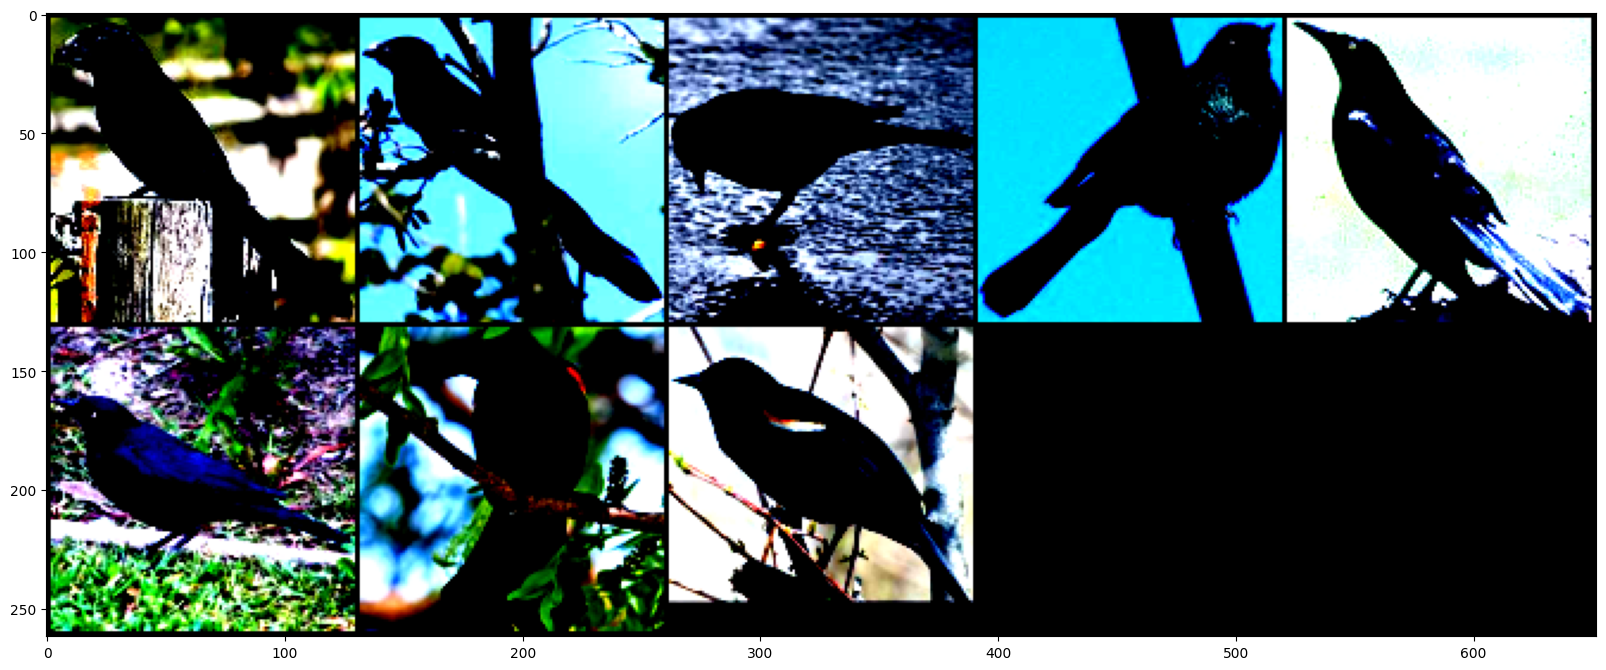

In [8]:
fig = plt.figure(figsize=(20, 20))
inputs, labels = next(iter(dm.val_dataloader()))
out = inputs.permute(0, 1, 2, 3)
out = torchvision.utils.make_grid(out, nrow=5)
out = np.transpose(out.detach().numpy(), (1, 2, 0))
plt.imshow(out)
plt.gca().grid(False)


In [ ]:
class FullImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = Path(root_dir)
        self.transform = transform
        self.files = [x for x in self.root_dir.glob("**/*") if x.is_file()]

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx: int):
        img_path = self.files[idx]
        image = Image.open(img_path).convert("RGB")
        width = image.width
        height = image.height

        if self.transform is not None:
            image = self.transform(image)

        return {"image": image, "path": img_path, "width": width, "height": height}


def collate_batch(batch):
    images = torch.stack([elem["image"] for elem in batch])
    paths = [elem["path"] for elem in batch]
    widths = [elem["width"] for elem in batch]
    heights = [elem["height"] for elem in batch]
    return {"images": images, "paths": paths, "widths": widths, "heights": heights}


class DataModule(pl.LightningDataModule):
    def __init__(
        self,
        config,
        path_to_datasets,
        train_transforms,
        val_transforms,
    ):
        super().__init__()
        self.config = config
        self.path_to_datasets = Path(path_to_datasets)
        self.train_transforms = train_transforms
        self.val_transforms = val_transforms

    def train_dataloader(self):
        return torch.utils.data.DataLoader(
            FullImageDataset(
                path_to_datasets / "train_images_cropped",
                transform=self.val_transforms,
            ),
            shuffle=True,
            batch_size=self.config["batch_size"],
            num_workers=self.config["num_workers"],
        )

    def val_dataloader(self):
        return torch.utils.data.DataLoader(
            FullImageDataset(
                path_to_datasets / "val_images_cropped",
                transform=self.val_transforms,
            ),
            batch_size=self.config["batch_size"],
            shuffle=False,
            num_workers=self.config["num_workers"],
        )

    def predict_dataloader(self):
        return torch.utils.data.DataLoader(
            FullImageDataset(
                path_to_datasets / "test_images_cropped",
                transform=self.val_transforms,
            ),
            batch_size=self.config["batch_size"],
            shuffle=False,
            num_workers=self.config["num_workers"],
        )


In [10]:
config = {}
config["batch_size"] = 16
config["width"] = 384
config["device"] = device
config["learning_rate"] = 0.0001
config["weight_decay"] = 0.01
config["num_workers"] = num_workers

data_transforms = transforms.Compose(
    [
        transforms.Resize(
            (config["width"], config["width"]),
            interpolation=transforms.InterpolationMode.BICUBIC,
        ),
        transforms.CenterCrop(384),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        #         transforms.ColorJitter(brightness=0.2, contrast=0.2),
        #         transforms.RandomAffine(degrees=15, translate=(0, 0.3), scale=(0.7, 1.3)),
        transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3)),
    ]
)

val_data_transforms = transforms.Compose(data_transforms.transforms[:3])

dm = DataModule(
    config,
    path_to_datasets="/kaggle/input/recvis3/bird_dataset",
    class_to_idx=class_to_idx,
    train_transforms=data_transforms,
    val_transforms=val_data_transforms,
)

fig = plt.figure(figsize=(20, 20))
batch = next(iter(dm.train_dataloader()))
out = batch["images"].permute(0, 1, 2, 3)
out = torchvision.utils.make_grid(out, nrow=5)
out = np.transpose(out.detach().numpy(), (1, 2, 0))
plt.imshow(out)
plt.gca().grid(False)


VisionTransformer(
  (conv_proj): Conv2d(3, 1280, kernel_size=(14, 14), stride=(14, 14))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=1280, out_features=1280, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=1280, out_features=5120, bias=True)
          (1): GELU(approximate=none)
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=5120, out_features=1280, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (

In [ ]:
def dfs_freeze(model):
    for _, child in model.named_children():
        for param in child.parameters():
            param.requires_grad = False
        dfs_freeze(child)


def dfs_unfreeze(model):
    for _, child in model.named_children():
        for param in child.parameters():
            param.requires_grad = True
        dfs_unfreeze(child)


class PreTrainedModel(pl.LightningModule):
    def __init__(self, config: Dict):
        super().__init__()

        self.config = config
        self.config["model_type"] = type(self)

        self.configure_model()
        self.configure_criterion()

    def configure_model(self):
        self.model = pretrained_models.resnet101(
            pretrained=True
        )  # weights="IMAGENET1K_V1")
        dfs_freeze(self.model)
        self.model.fc = nn.Sequential(
            nn.Flatten(),
            nn.LazyLinear(out_features=128),
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.Linear(in_features=128, out_features=20),
        )
        #         self.model = pretrained_models.efficientnet_b6(pretrained=True) #weights="IMAGENET1K_V1")
        #         dfs_freeze(self.model)
        #         self.model.classifier = nn.Sequential(
        #             nn.Flatten(),
        #             nn.LazyLinear(out_features=256),
        #             nn.ReLU(),
        #             nn.Dropout(p=0.5),
        #             nn.Linear(in_features=256, out_features=20),
        #         )
        self.config["model"] = type(self.model)

    def forward(self, x):
        x = self.model(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        predictions = y_hat.data.max(1, keepdim=True)[1]

        loss = self.criterion(y_hat, y)
        accuracy = torchmetrics.Accuracy().to(self.config["device"])(
            torch.squeeze(predictions), y
        )
        self.log_dict(
            {"train/loss": loss, "train/accuracy": accuracy},
            on_step=True,
            on_epoch=True,
        )
        n_correct_pred = predictions.eq(y.data.view_as(predictions)).sum().detach()
        return {"loss": loss, "n_correct_pred": n_correct_pred, "n_pred": len(y)}

    def training_epoch_end(self, outputs):
        train_acc = sum([x["n_correct_pred"] for x in outputs]) / sum(
            x["n_pred"] for x in outputs
        )
        self.log(
            "train_acc",
            train_acc,
            prog_bar=True,
        )

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        predictions = y_hat.data.max(1, keepdim=True)[1]

        loss = self.criterion(y_hat, y)
        accuracy = torchmetrics.Accuracy().to(self.config["device"])(
            torch.squeeze(predictions), y
        )
        self.log_dict(
            {"val/loss": loss, "val/accuracy": accuracy},
            on_step=True,
            on_epoch=True,
        )
        n_correct_pred = predictions.eq(y.data.view_as(predictions)).sum().detach()
        return {"val_loss": loss, "n_correct_pred": n_correct_pred, "n_pred": len(y)}

    def validation_epoch_end(self, outputs):
        val_acc = sum([x["n_correct_pred"] for x in outputs]) / sum(
            x["n_pred"] for x in outputs
        )
        self.log(
            "val_acc",
            val_acc,
            prog_bar=True,
        )

    def predict_step(self, batch, batch_idx: int, dataloader_idx: int = None):
        if isinstance(batch, tuple) or isinstance(batch, list):
            y_hat = self(batch[0])
        else:
            y_hat = self(batch)
        predictions = y_hat.data.max(1, keepdim=True)[1]
        return predictions

    def configure_criterion(self):
        """Configures the criterion / loss"""
        self.criterion = torch.nn.CrossEntropyLoss(reduction="mean")
        self.config["loss_type"] = type(self.criterion)

    def configure_optimizers(self) -> torch.optim:
        optimizer = torch.optim.Adam(
            self.parameters(),
            lr=self.config["learning_rate"],
            weight_decay=self.config["weight_decay"],
        )
        self.config["optimizer_type"] = type(optimizer)
        lr_scheduler = ReduceLROnPlateau(optimizer, patience=5)
        return {
            "optimizer": optimizer,
            "lr_scheduler": lr_scheduler,
            "monitor": "train/loss",
        }


model_checkpoint = ModelCheckpoint(
    dirpath="tmp/",
    filename="epoch={epoch}-loss={val/loss_epoch:.3f}-accuracy={val/accuracy_epoch:.3f}",
    auto_insert_metric_name=False,
    monitor="val/accuracy_epoch",
    mode="max",
    verbose=True,
    save_last=False,
    save_top_k=1,
)

model = PreTrainedModel(config)
model(next(iter(dm.train_dataloader()))[0])

neptune_logger = NeptuneLogger(
    project="matiasetcheverry/RECVIS3",
    api_key="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIwNDFmMDY3MC1iMWIxLTRlMGUtOTg4Ni1hMmY1NjZjNDM2NDYifQ==",
    log_model_checkpoints=False,
)

neptune_logger.log_model_summary(model=model, max_depth=-1)
neptune_logger.log_hyperparams(params=config)

trainer = pl.Trainer(
    max_epochs=100,
    callbacks=[model_checkpoint],
    devices="auto",
    accelerator="auto",
    log_every_n_steps=10,
    logger=neptune_logger,
)

trainer.fit(
    model,
    datamodule=dm,
)


Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/loggers/neptune.py:443: NeptuneDeprecationWarning: `init` is deprecated, use `init_run` instead. We'll end support of it in `neptune-client==1.0.0`.
  self._run_instance = neptune.init(**self._neptune_init_args)


https://app.neptune.ai/matiasetcheverry/RECVIS3/e/REC-8
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


/opt/conda/lib/python3.7/site-packages/neptune/new/handler.py:164: NeptuneDeprecationWarning: The object you're logging will be implicitly cast to a string. We'll end support of this behavior in `neptune-client==1.0.0`. To log the object as a string, use `str(object)` instead.
  self._container.define(self._path, value, wait)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [ ]:
dfs_unfreeze(model.model)
trainer = pl.Trainer(
    max_epochs=100,
    callbacks=[model_checkpoint],  # early_stopping],
    devices="auto",
    accelerator="auto",
    log_every_n_steps=10,
    #     logger=logger,
)
trainer.fit(
    model,
    datamodule=dm,
)


/opt/conda/lib/python3.7/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint directory /kaggle/working/tmp exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Run REC-4 received stop signal. Exiting
Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 4 operations to synchronize with Neptune. Do not kill this process.
All 4 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/matiasetcheverry/RECVIS3/e/REC-4


In [ ]:
model = torch.hub.load("facebookresearch/detr", "detr_resnet50", pretrained=True)
model.eval()
3


In [ ]:
transform = transforms.Compose(
    [
        transforms.Resize(800),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)


In [ ]:
im = Image.open(
    str(
        Path(
            "bird_dataset/train_images/004.Groove_billed_Ani/Groove_Billed_Ani_0006_1763.jpg"
        )
    )
)

# mean-std normalize the input image (batch-size: 1)
img = transform(im).unsqueeze(0)

# propagate through the model
outputs = model(img)

# keep only predictions with 0.7+ confidence
probas = outputs["pred_logits"].softmax(-1)[0, :, :-1]
keep = probas.max(-1).values > 0.9

# convert boxes from [0; 1] to image scales
bboxes_scaled = rescale_bboxes(outputs["pred_boxes"][0, keep], im.size)

plot_results(im, probas[keep], bboxes_scaled)


In [ ]:
def compute_accuracy_confusion(model, loader):
    y_pred = []
    y_true = []

    for inputs, labels in loader:
        output = model(inputs)
        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output)  # Save Prediction

        labels = labels.data.cpu().numpy()
        y_true.extend(labels)  # Save Truth
    accuracy = accuracy_score(y_true, y_pred)
    cf_matrix = confusion_matrix(y_true, y_pred)
    classes = list(train_loader.dataset.class_to_idx.keys())
    df_cm = pd.DataFrame(
        cf_matrix / np.sum(cf_matrix, axis=1)[:, None],
        index=[i for i in classes],
        columns=[i for i in classes],
    )
    return accuracy, df_cm


# accuracy, cf_dataframe = compute_accuracy_confusion(model, train_loader)
plt.figure(figsize=(12, 7))
sns.heatmap(cf_dataframe, annot=True)

# row : true label
# col : predicted label


In [ ]:
class PreTrainedRegnet(nn.Module):
    def __init__(self, config: Optional[Dict] = {}):
        super().__init__()

        self.config = config

        self.configure_model()

    def configure_model(self):
        # fully connected linear layers
        self.model = pretrained_models.efficientnet_b0(weights="IMAGENET1K_V1")
        dfs_freeze(self.model)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.LazyLinear(out_features=20),
        )

    def forward(self, x):
        x = self.model(x)
        x = self.classifier(x)
        return x


model = PreTrainedRegnet()
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
    weight_decay=weight_decay,
)
learning_rate = 1e-3
weight_decay = 0.01
train(model, train_loader, val_loader, optimizer, 20, save=False)


In [ ]:
model = pretrained_models.efficientnet_v2_l(weights="IMAGENET1K_V1")
model.classifier
